#Downloading required packages


In [0]:
!pip install gpyopt
!pip install pycuda
!pip install pyro-ppl==0.3.2

#Loading libraries


In [0]:
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.distributions import  Bernoulli
from functools import partial
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
import fileinput
import requests
import GPyOpt
import pycuda.driver as cuda
cuda.init()

#Loading data

This is mostly boiler plate code, except for the boston and yacht datasets, every data is read directly from the source on github. For the case of boston and yacht datasets, we download them locally to fix some issues concerning the separator between each columns.

Each dataset call is then associated to a function.

In [0]:
### Loading data 
""" 
This is mostly boiler plate code, except the boston and yacht datasets, every data is read directly from the 
source on github. For the case of boston and yacht datasets, we download them locally to fix some issues concerning
the separator between each columns.
"""
boston_url = "https://media.githubusercontent.com/media/probabilisticai/dt8122/master/datasets/boston_housing.txt"
concrete_url = "https://media.githubusercontent.com/media/probabilisticai/dt8122/master/datasets/concrete.txt"
energy_url = "https://media.githubusercontent.com/media/probabilisticai/dt8122/master/datasets/energy_heating_load.txt"
kin8_url = "https://media.githubusercontent.com/media/probabilisticai/dt8122/master/datasets/kin8nm.txt"
naval_url = "https://media.githubusercontent.com/media/probabilisticai/dt8122/master/datasets/naval_compressor_decay.txt"
power_url = "https://media.githubusercontent.com/media/probabilisticai/dt8122/master/datasets/power.txt"
protein_url = "https://media.githubusercontent.com/media/probabilisticai/dt8122/master/datasets/protein.txt"
wine_url = "https://media.githubusercontent.com/media/probabilisticai/dt8122/master/datasets/wine.txt"
yacht_url = "https://media.githubusercontent.com/media/probabilisticai/dt8122/master/datasets/yacht.txt"
year_prediction_url = "https://media.githubusercontent.com/media/probabilisticai/dt8122/master/datasets/year_prediction_msd.txt"


def boston():
  r = requests.get(boston_url)
  with open('/content/boston.txt', 'wb') as f:  
    f.write(r.content)
  with fileinput.FileInput("boston.txt", inplace=True, backup='.bak') as file:
    for line in file:
        print(line.replace("   ", " "), end='')
  bos = [str(i) for i in range(14)]
  boston = pd.read_csv('boston.txt', sep="  | ",names = bos, header=None)
  print("Boston dataset - {} examples - 14 columns".format(len(boston)))
  print("Number of Nan :{}".format(boston.isna().sum().sum())) 
  return boston, 14, "Boston Housing"

def concrete():
  conc = [str(i) for i in range(9)]
  concrete = pd.read_csv(concrete_url, sep=" |\t",names = conc, header=None)
  print("Concrete dataset - {} examples - 9 columns".format(len(concrete)))
  print("Number of Nan :{}".format(concrete.isna().sum().sum())) 
  return concrete, 9, "Concrete Strength"

def energy():  
  ener = [str(i) for i in range(9)]
  energy = pd.read_csv(energy_url, sep=" |\t",names = ener, header=None)
  print("Energy dataset - {} examples - 9 columns".format(len(energy)))
  print("Number of Nan :{}".format(energy.isna().sum().sum())) 
  return energy, 9, "Energy Efficiency"

def kin8nm():
  kin8 = [str(i) for i in range(9)]
  kin8nm = pd.read_csv(kin8_url, sep="   |  ",names = kin8, header=None)
  print("Kin8nm dataset - {} examples - 10 columns".format(len(kin8nm)))
  print("Number of Nan :{}".format(kin8nm.isna().sum().sum())) 
  return kin8nm, 9, "Kin8nm"

def naval():
  nav = [str(i) for i in range(17)]
  naval = pd.read_csv(naval_url, sep=" |\t", names = nav, header=None)
  print("Naval dataset - {} examples - 17 columns".format(len(naval)))
  print("Number of Nan :{}".format(naval.isna().sum().sum())) 
  return naval, 17, "Naval Propulsion"

def power():
  pow = [str(i) for i in range(5)]
  power = pd.read_csv(power_url, sep=" |\t", names = pow, header=None)
  print("Power dataset - {} examples - 5 columns".format(len(power)))
  print("Number of Nan :{}".format(power.isna().sum().sum())) 
  return power, 5, "Power Plant"

def protein():
  prot = [str(i) for i in range(10)]
  protein = pd.read_csv(protein_url, sep=" |\t", names = prot, header=None)
  print("Protein dataset - {} examples - 10 columns".format(len(protein)))
  print("Number of Nan :{}".format(protein.isna().sum().sum())) 
  return protein, 10, "Protein Structure"

def wine():
  w = [str(i) for i in range(12)]
  wine = pd.read_csv(wine_url, sep=" |\t", names = w, header=None)
  print("Wine dataset - {} examples - 12 columns".format(len(wine)))
  print("Number of Nan :{}".format(wine.isna().sum().sum())) 
  return wine, 12, "Wine Quality Red"

def yacht(): 
  r = requests.get(yacht_url)
  with open('/content/yacht.txt', 'wb') as f:  
      f.write(r.content) 
  with fileinput.FileInput("yacht.txt", inplace=True, backup='.bak') as file:
    for line in file:
        print(line.replace("  ", " "), end='')
  ya = [str(i) for i in range(7)]        
  yacht = pd.read_csv('yacht.txt', sep=" ", names = ya, header=None)
  print("Yacht dataset - {} examples - 7 columns".format(len(yacht)))
  print("Number of Nan :{}".format(yacht.isna().sum().sum())) 
  return yacht, 7, "Yacht Hydrodynamics"

def year_prediction():
  year = [str(i) for i in range(90)]
  year_prediction = pd.read_csv(year_prediction_url, sep=" ", names = year, header=None)
  print("Year_prediction_msd dataset - {} examples - 90 columns".format(len(year_prediction)))
  print("Number of Nan :{}".format(year_prediction.isna().sum().sum())) 
  return year_prediction, 90, "Year Prediction MSD"


  

Here you can select the dataset you want to load in by selecting the appropriate function. The rest of the code is going to split a training and test set, and then put the data in cuda tensors.

In [0]:
data, nb_features, name = year_prediction()
nb_features = nb_features-1
col = str(nb_features) 
x = data.drop(col, axis=1)
y = data[col]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_tensor_type('torch.cuda.FloatTensor')

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42)

x_train = np.array(x_train, dtype='float32')
y_train = np.array(y_train, dtype='float32')
x_test = np.array(x_test, dtype='float32')
y_test = np.array(y_test, dtype='float32')

x_train_tensor = torch.tensor(np.array(x_train),device = device)
y_train_tensor = torch.tensor(np.array(y_train),device = device)
x_test_tensor = torch.tensor(np.array(x_test), device = device)
y_test_tensor = torch.tensor(np.array(y_test), device = device)



Year_prediction_msd dataset - 515345 examples - 90 columns
Number of Nan :0


#Model Definition
We define a 3 hidden layer neural net using the Scaled Exponential Linear Unit  activation function. We also add a residual connection.

In [0]:
# Model

class VariationalDropout(nn.Module):
    def __init__(self, input_dim, output_dim, keep_prob, model_lambda):
        super(VariationalDropout, self).__init__()
        self.M = nn.Parameter(torch.rand(input_dim, output_dim))
        self.m = nn.Parameter(torch.zeros(output_dim))
        self.keep_prob = keep_prob
        self.bernoulli = Bernoulli(probs=keep_prob)
        self.model_lambda = model_lambda
        self.input_dim = input_dim
    
    def forward(self,x):
        # return x.w + b
        W = torch.mm(torch.diag(self.bernoulli.sample([self.input_dim])), self.M)
        return torch.mm(x, W)+ self.m
    
    @property
    def regularization(self):
        return self.model_lambda * (
                self.keep_prob * torch.sum(torch.pow(self.M,2))+ 
                torch.sum(torch.pow(self.m,2))
                )

class DeepVariationalDropout(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, keep_prob, model_lambda):
        super(DeepVariationalDropout, self).__init__()
        self.L1 = VariationalDropout(input_dim,hidden_dim,keep_prob, model_lambda).cuda()
        self.L2 = VariationalDropout(hidden_dim,hidden_dim,keep_prob, model_lambda).cuda()
        self.L3 = VariationalDropout(hidden_dim, 1,keep_prob, model_lambda).cuda()

    
    def forward(self,x):
        h1 = F.selu(self.L1(x))
        h2 = F.selu(self.L2(h1)) 
        out = self.L3(h2) 
        return out
    
    @property
    def regularization(self):
        return self.L1.regularization + self.L2.regularization + self.L3.regularization


#Hyperparameter search
We first run the model for 5 epochs to get a baseline score before appliying bayesian optimization.

In [0]:
## Baseline neural net
model_lambda = 1e-2
keep_prob = .8    
hidden_dim = 100

neural_net = DeepVariationalDropout(nb_features, hidden_dim, 1, keep_prob, model_lambda).cuda()


criterion = nn.MSELoss()  
optimizer = optim.Adam(neural_net.parameters(), lr=0.0001)

# Training
epochs = 5

for i in range(epochs):
    # Zero the gradients before running the backward pass.
    neural_net.zero_grad()

    # Forward propagation
    out = neural_net(x_train_tensor).squeeze(-1)
    rmse =  criterion(y_train_tensor,out)
    loss = rmse + neural_net.regularization
    # Backward pass: compute gradient of the loss with respect to all the learnable
    # parameters of the model. Internally, the parameters of each Module are stored
    # in Tensors with requires_grad=Trupae, so this call will compute gradients for
    # all learnable parameters in the model.
    loss.backward(retain_graph=True)
    # Update the weights using gradient descent. Each parameter is a Tensor, so
    # we can access its gradients like we did before.
    optimizer.step()

rmse =  criterion(y_train_tensor,out)
loss = rmse + neural_net.regularization
baseline_score = loss.detach().cpu().numpy()

We then define the function to optimize. Basically we want to reduce the loss after 5 epochs, depending on learning rate and the hidden dimension. We are going to search the model $\lambda$ between 0.001 and 0.1, and the learning rate between 0.0001 and 0.01. Finaly we use the Maximum Probability of Improvement as the acquisition function in the Gaussian process.

In [0]:
keep_prob = .8    

def model_to_optimize(x):
  """
  Function to optimize with Bayesian Optimization (BO)
  we basically run our model with different model_lambda and different learning rate.
  """
  learning_rate = float(x[:,0])
  model_lambda = float(x[:,1])
  hidden_dim = int(x[:,2])
  neural_net = DeepVariationalDropout(nb_features, hidden_dim, 1, keep_prob, model_lambda).cuda()
  criterion = nn.MSELoss()  
  optimizer = optim.Adam(neural_net.parameters(), lr=learning_rate)
  # Training
  epochs = 5
  for i in range(epochs):
      # Zero the gradients before running the backward pass.
      neural_net.zero_grad()

      # Forward propagation
      out = neural_net(x_train_tensor).squeeze(-1)
      rmse =  criterion(y_train_tensor,out)
      loss = rmse + neural_net.regularization
      loss.backward(retain_graph=True) 
      # Update the weights using gradient descent. Each parameter is a Tensor, so
      # we can access its gradients like we did before.
      optimizer.step()
  # Evaluating the trained model after 5 epochs      
  rmse =  criterion(y_train_tensor,out)
  loss = rmse + neural_net.regularization 
  
  return loss.detach().cpu().numpy()


bounds = [
            {'name': 'learning_rate', 'type': 'continuous', 'domain': (10**-4,10**-2)},
            {'name': 'model_lambda', 'type': 'continuous', 'domain': (10**-3,10**-1)},
            {'name': 'hidden_dim', 'type': 'discrete', 'domain': np.arange(10,100)},
         ]
optimizer = GPyOpt.methods.BayesianOptimization(f=model_to_optimize, domain=bounds,
                                                        acquisition_type = 'MPI',
                                                        acquisition_par = 0.1,                                                    
                                                        model_type='GP')


best learning rate: 0.01
best model lambda: 0.001
best hidden dimension : 36.0
The performance boost after 20 iteration is : 33139.0 %


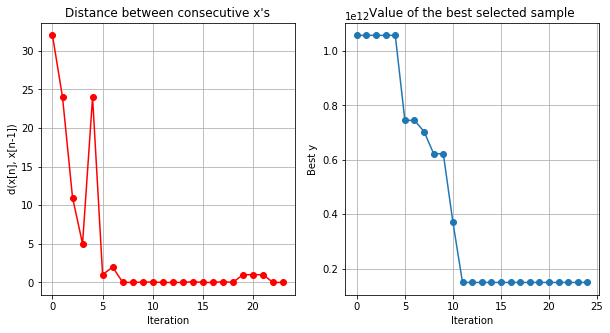

In [0]:
optimizer.run_optimization(max_iter=20, eps=-1)

## Bayesian Optimization Evaluation

best_hyperparameters = optimizer.X[np.argmin(optimizer.Y)]
performance_boost_20_run = (baseline_score/np.min(optimizer.Y) -1)*100
print("best learning rate: {}".format(best_hyperparameters[0]))
print("best model lambda: {}".format(best_hyperparameters[1]))
print("best hidden dimension : {}".format(best_hyperparameters[2]))
print("The performance boost after 20 iteration is : {} %".format(np.floor(performance_boost_20_run)))

# Plot the optimizer convergence
# two graphs, the first describe the distance between a set of hyperparameters
# at a given evaluation to another; the second graph shows an evolution
# of the value of the lowest loss we found.
optimizer.plot_convergence()

In [0]:
model_lambda = best_hyperparameters[1]
keep_prob1 = .8    
hidden_dim = int(best_hyperparameters[2])

neural_net = DeepVariationalDropout(nb_features, hidden_dim, 1, keep_prob, model_lambda).cuda()

criterion = nn.MSELoss()  
optimizer = optim.Adam(neural_net.parameters(), lr=best_hyperparameters[0])

losses = []
# Training
epochs = 35000

for i in range(epochs):
    # Zero the gradients before running the backward pass.
    neural_net.zero_grad()

    # Forward propagation
    out = neural_net(x_train_tensor).squeeze(-1)
    rmse =  criterion(y_train_tensor,out)
    loss = rmse + neural_net.regularization
    # Backward prop
    loss.backward(retain_graph=True)
    losses.append(loss.item())
    if i % 500 == 0:
            print("[iteration %04d] loss: %.4f" % (i, loss ))

    # Update the weights using gradient descent. Each parameter is a Tensor, so
    # we can access its gradients like we did before.
    optimizer.step()



[iteration 0000] loss: 1507544793088.0000
[iteration 0500] loss: 69401808.0000
[iteration 1000] loss: 12365360.0000
[iteration 1500] loss: 87019312.0000
[iteration 2000] loss: 9388382.0000
[iteration 2500] loss: 52592456.0000
[iteration 3000] loss: 13055536.0000
[iteration 3500] loss: 1449464.5000
[iteration 4000] loss: 2537192.0000
[iteration 4500] loss: 4036804.7500
[iteration 5000] loss: 4183778.7500
[iteration 5500] loss: 4524121.5000
[iteration 6000] loss: 13264958.0000
[iteration 6500] loss: 1366708.6250
[iteration 7000] loss: 2095827.7500
[iteration 7500] loss: 1279361.8750
[iteration 8000] loss: 1151826.1250
[iteration 8500] loss: 1002199.3750
[iteration 9000] loss: 1256566.2500
[iteration 9500] loss: 1042415.6875
[iteration 10000] loss: 636777.8750
[iteration 10500] loss: 836388.3125
[iteration 11000] loss: 533881.2500
[iteration 11500] loss: 568265.1250
[iteration 12000] loss: 528141.0625
[iteration 12500] loss: 533709.0000
[iteration 13000] loss: 457467.6875
[iteration 13500

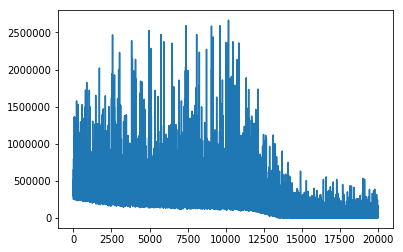

In [0]:
cost = np.array(losses[15000:])    
t = np.arange(epochs-15000)    
plt.plot(t,cost) 

It is very likely that you will need to save the neural network and evaluate it locally if the dataset is year prediction msd. Otherwise you can skip this command and direclty evaluate the model.

In [0]:
torch.save(neural_net, 'neural_net_dropout_2')

#Model Evaluation

In [0]:

######### Evaluate the model
# Those utility functions are going to be used further the line to evaluate the predictions.
def picp(y, y_lower, y_upper):
    batch_size = len(y)
    k = np.zeros(batch_size)
    for i in range(batch_size):
        k[i] = y_lower[i] <= y[i] <= y_upper[i]
    return np.mean(k)

def mpiw(y_lower, y_upper):
    return np.mean(y_upper-y_lower)
    
def EmpiricalDistribution(x_data, model, num_sample):
    predictions = torch.zeros((num_sample, len(x_data)))
    for i in range(num_sample):
        prediction_mean = model(x_data)
        predictions[i] = prediction_mean.squeeze(-1)
    return predictions   


In [0]:
num_sample = 1000
predictions = EmpiricalDistribution(x_test_tensor,neural_net,num_sample)
predictions = predictions.detach().cpu().numpy()


marginal_site = pd.DataFrame(predictions).transpose()
describe = partial(pd.Series.describe, percentiles=[.025, 0.5, 0.975])
summary = marginal_site.apply(describe, axis=1)[["mean", "std", "2.5%", "50%", "97.5%"]]

y_test_lower = np.array(summary['2.5%'])
y_test_upper = np.array(summary['97.5%'])
y_test_mean =  np.array(summary['mean'])
y_test_median = np.array(summary['50%'])

proba_coverage_test = picp(y_test, y_test_lower, y_test_upper)
interval_predicted_test = mpiw(y_test_lower, y_test_upper)
rmse_test = np.mean(np.sqrt(np.power((y_test_mean-y_test),2)))

interval_def = np.max(y) - np.min(y)


In [0]:
print("{} dataset".format(name))
print("Prediction Interval Coverage Probability (PICP): {}".format(proba_coverage_test))
print("Mean Prediction Interval Width (MPIW): {}".format(interval_predicted_test))
print("Natural Interval Width of Data: {}".format(interval_def))
print("Root Mean Square Error (RMSE): {}".format(rmse_test))


Concrete Strength dataset
Prediction Interval Coverage Probability (PICP): 0.9029126213592233
Mean Prediction Interval Width (MPIW): 53.1532989889745
Natural Interval Width of Data: 80.27
Root Mean Square Error (RMSE): 13.140986137019778
